In [1]:
import os
import cv2
import numpy as np
import json
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical

In [2]:
# Dataset Paths
DATASET_PATH = "/Users/pillisachethan/Desktop/DNN/project/UCF11_updated_mpg"
SAVE_DIR = "/Users/pillisachethan/Desktop/DNN/project/processed_data"
os.makedirs(SAVE_DIR, exist_ok=True)

# Constants
FRAME_COUNT = 16
IMG_SIZE = 224 
VIDEO_EXTENSIONS = ('.mpg', '.avi', '.mp4', '.mov')

In [3]:
# Class Names
CLASSES = sorted([cls for cls in os.listdir(DATASET_PATH) 
                  if not cls.startswith('.') and not cls.lower().startswith('annotation')])
label_map = {cls: idx for idx, cls in enumerate(CLASSES)}

print("Label Mapping:", label_map)

Label Mapping: {'basketball': 0, 'biking': 1, 'diving': 2, 'golf_swing': 3, 'horse_riding': 4, 'soccer_juggling': 5, 'swing': 6, 'tennis_swing': 7, 'trampoline_jumping': 8, 'volleyball_spiking': 9, 'walking': 10}


In [4]:
def load_video_frames(video_path, num_frames=FRAME_COUNT):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_indices = np.linspace(0, total_frames-1, num=num_frames, dtype=int)

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    cap.release()

    if len(frames) == 0:
        return None 

   
    while len(frames) < num_frames:
        frames.append(frames[-1])

    return np.array(frames, dtype=np.float32) / 255.0

In [5]:
X, y = [], []
labels = {}
video_id = 0

print(" Extracting frames and preparing data...")

for class_name in tqdm(CLASSES):
    class_folder = os.path.join(DATASET_PATH, class_name)

    for subfolder in os.listdir(class_folder):
        subfolder_path = os.path.join(class_folder, subfolder)

        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                if file.endswith(VIDEO_EXTENSIONS):
                    video_path = os.path.join(subfolder_path, file)
                    frames = load_video_frames(video_path)

                    if frames is not None:
                        filename = f"video_{video_id}.npy"
                        np.save(os.path.join(SAVE_DIR, filename), frames)

                        labels[filename] = class_name
                        X.append(frames)
                        y.append(label_map[class_name])
                        video_id += 1

# Save Labels
with open(os.path.join(SAVE_DIR, "labels.json"), "w") as f:
    json.dump(labels, f)

print(f"Processed {video_id} videos.")

 Extracting frames and preparing data...


100%|███████████████████████████████████████████| 11/11 [00:35<00:00,  3.27s/it]

Processed 1599 videos.


In [6]:
X = np.array(X, dtype=np.float32)
y = to_categorical(y, num_classes=len(CLASSES))

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1599, 16, 224, 224, 3)
y shape: (1599, 11)


In [7]:
# Split into train, validation, test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Shuffle training data
X_train, y_train = shuffle(X_train, y_train, random_state=42)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (1279, 16, 224, 224, 3)
Validation shape: (160, 16, 224, 224, 3)
Test shape: (160, 16, 224, 224, 3)


In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization,
    TimeDistributed, LSTM, GlobalAveragePooling3D
)
from tensorflow.keras.regularizers import l2

input_shape = (FRAME_COUNT, IMG_SIZE, IMG_SIZE, 3)
num_classes = len(CLASSES)

inputs = Input(shape=input_shape)

# 3D CNN Layers
x = Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(inputs)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)
x = BatchNormalization()(x)

x = Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)
x = BatchNormalization()(x)

x = Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
x = MaxPooling3D(pool_size=(1, 2, 2))(x)
x = BatchNormalization()(x)

# LSTM
x = TimeDistributed(Flatten())(x)  # Flatten each timestep
x = LSTM(64, return_sequences=False, dropout=0.5)(x)

# Dense Layers
x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 16, 224, 224,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 8, 112, 112,    │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 112, 112,    │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 8, 112, 112,    │        55,360 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 4, 56, 56, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 56, 56, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 4, 56, 56, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 4, 28, 28, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 28, 28, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 4, 100352)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │    25,706,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,996,683 (99.17 MB)

 Trainable params: 25,996,235 (99.17 MB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

In [10]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=8,
    callbacks=callbacks
)

Epoch 1/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 1340s 8s/step - accuracy: 0.1961 - loss: 2.3160 - val_accuracy: 0.1250 - val_loss: 2.3887 - learning_rate: 1.0000e-04
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 1391s 9s/step - accuracy: 0.3536 - loss: 1.9887 - val_accuracy: 0.2500 - val_loss: 2.1762 - learning_rate: 1.0000e-04
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 1390s 9s/step - accuracy: 0.4354 - loss: 1.7675 - val_accuracy: 0.4812 - val_loss: 1.7716 - learning_rate: 1.0000e-04
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 1431s 9s/step - accuracy: 0.5384 - loss: 1.6052 - val_accuracy: 0.4500 - val_loss: 1.7144 - learning_rate: 1.0000e-04
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 1426s 9s/step - accuracy: 0.5864 - loss: 1.4475 - val_accuracy: 0.6062 - val_loss: 1.4479 - learning_rate: 1.0000e-04
Epoch 6/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 1415s 9s/step - accuracy: 0.6001 - loss: 1.3564 - val_accuracy: 0.6187 - val_loss: 1.2940 - learning_rate: 1.0000e-04
Epoch 7/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 1397s 9s/ste

5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step
                    precision    recall  f1-score   support

        basketball       0.92      0.86      0.89        14
            biking       0.64      0.64      0.64        14
            diving       0.93      0.88      0.90        16
        golf_swing       1.00      0.93      0.96        14
      horse_riding       0.86      0.90      0.88        20
   soccer_juggling       0.88      0.88      0.88        16
             swing       0.86      0.86      0.86        14
      tennis_swing       1.00      1.00      1.00        17
trampoline_jumping       0.75      1.00      0.86        12
volleyball_spiking       0.80      0.73      0.76        11
           walking       0.73      0.67      0.70        12

          accuracy                           0.86       160
         macro avg       0.85      0.85      0.85       160
      weighted avg       0.86      0.86      0.86       160



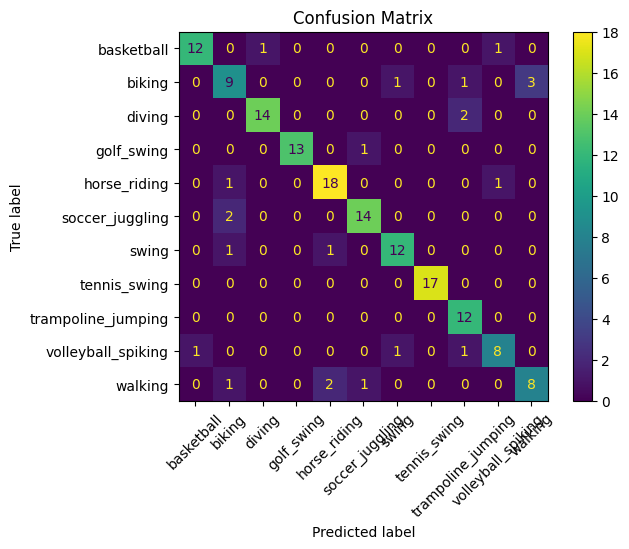

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred, target_names=CLASSES))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

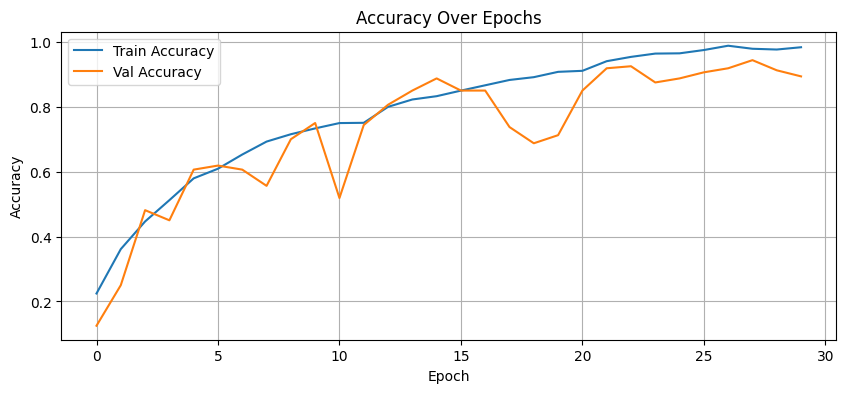

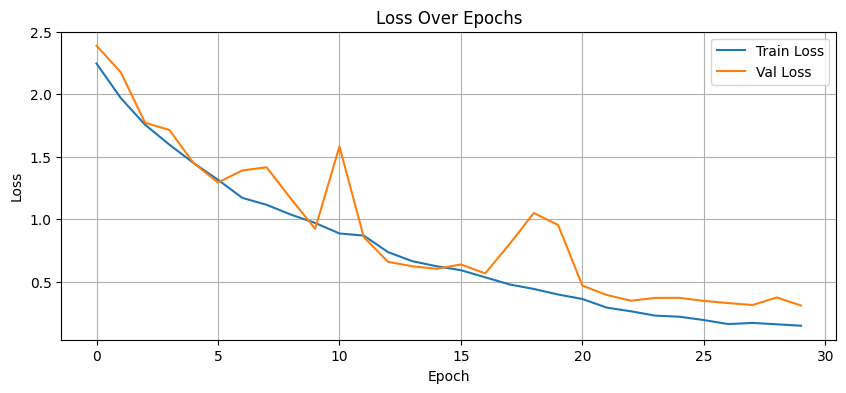

In [12]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.legend()
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


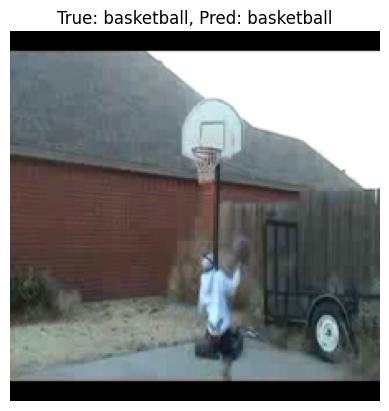

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


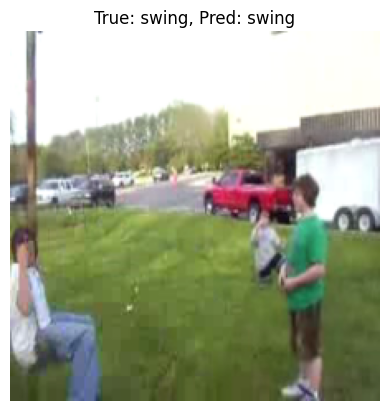

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


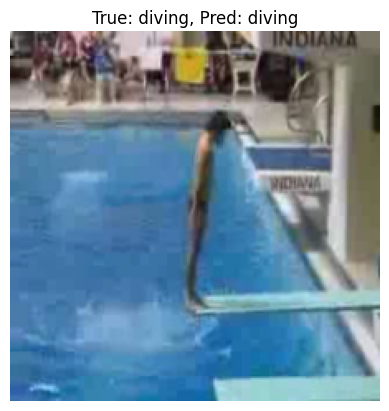

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


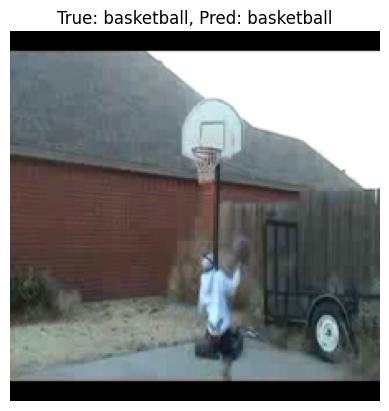

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


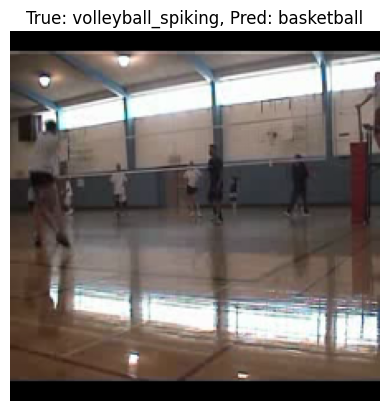

In [13]:
import random

for _ in range(5):
    idx = random.randint(0, len(X_test) - 1)
    video = X_test[idx]
    label = np.argmax(y_test[idx])
    pred = np.argmax(model.predict(video[np.newaxis, ...]))

    plt.imshow(video[0]) 
    plt.title(f"True: {CLASSES[label]}, Pred: {CLASSES[pred]}")
    plt.axis('off')
    plt.show()